# **Projekt: Fehlererkennung in Getrieben**
## Netztyp 2: FFT-Net

#### **Vorbereitung**

In [ ]:
# import libraries
import os
from pathlib import Path

# module imports from /src
if Path.cwd().stem == "notebooks":
    os.chdir( Path.cwd().parent)

import src.data_loader as dl
import src.visualization as vis
import src.net_models as net
import src.input_preparation as ip

In [3]:
# set the source directory for the preprocessed data to use
SOURCE: str = "f2fcf2aa-bd96-4d89-8bb5-4a0a1bc11b1b"

# setup a single index for control purposes
CONTROL_INDEX: int = 0

In [4]:
# setup system and check the number of cpu cores and gpus available
net.system_setup()

Number of CPU cores:		12
Number of GPUs available:	0


#### **Laden der Datensätze**

In [5]:
# load data from folder and split in training and evaluation data
data_path = Path().cwd() / "data" / "processed" / SOURCE
development_data, evaluation_data = dl.load_all_datasets(data_path)

load_all_datasets():
	Reading development data ...
	0D_0_fft.csv successfully loaded.
	0D_1_fft.csv successfully loaded.
	1D_0_fft.csv successfully loaded.
	1D_1_fft.csv successfully loaded.
	2D_0_fft.csv successfully loaded.
	2D_1_fft.csv successfully loaded.
	3D_0_fft.csv successfully loaded.
	3D_1_fft.csv successfully loaded.
	4D_0_fft.csv successfully loaded.
	4D_1_fft.csv successfully loaded.
	Reading evaluation data ...
	0E_0_fft.csv successfully loaded.
	0E_1_fft.csv successfully loaded.
	1E_0_fft.csv successfully loaded.
	1E_1_fft.csv successfully loaded.
	2E_0_fft.csv successfully loaded.
	2E_1_fft.csv successfully loaded.
	3E_0_fft.csv successfully loaded.
	3E_1_fft.csv successfully loaded.
	4E_0_fft.csv successfully loaded.
	4E_1_fft.csv successfully loaded.
	Reading completed.



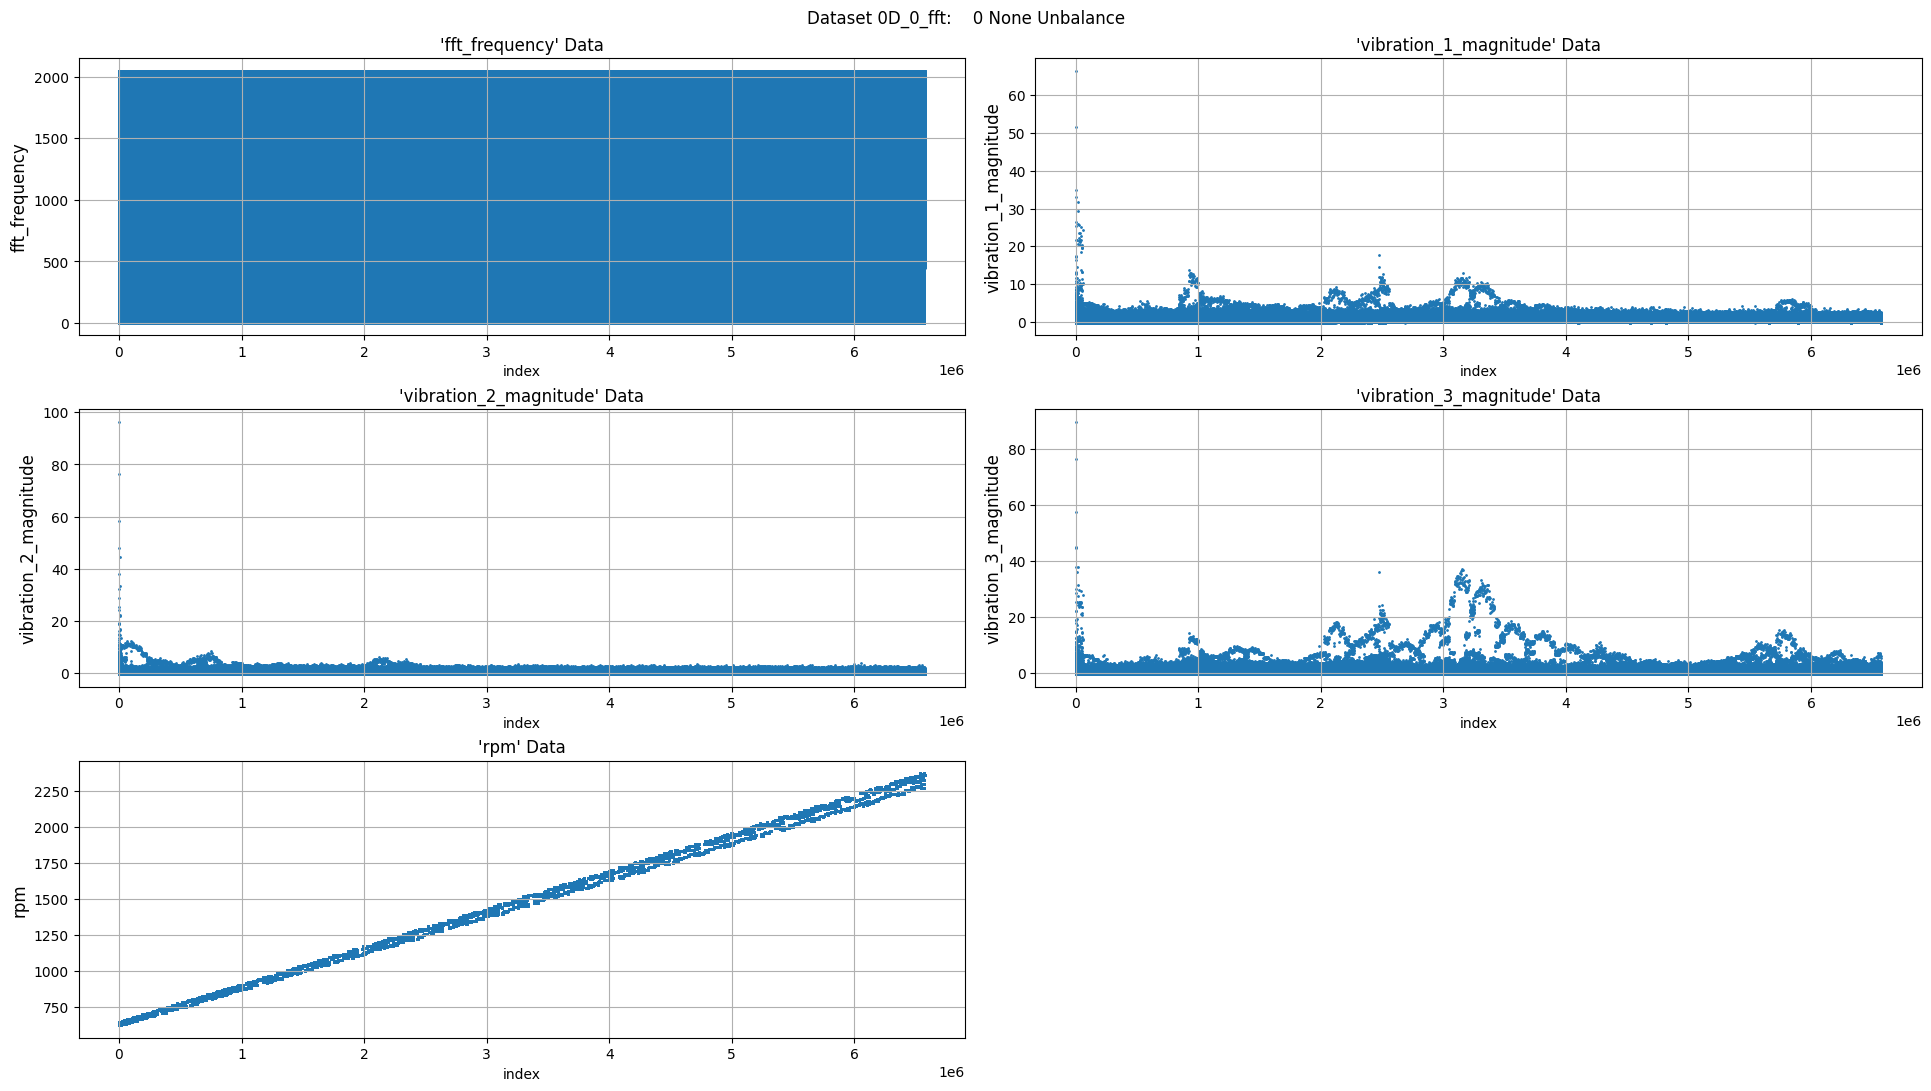

In [6]:
# visualize one random dataset for data validation
vis.plot_column_data(development_data[CONTROL_INDEX],
                             development_data[CONTROL_INDEX].columns)

#### **Das Neuronale Netz**

In [7]:
full_development_dataset = ip.concatenate_datasets(development_data)

training_samples_dict = ip.split_data(
    dataframe=full_development_dataset,
    data_columns=[
        "vibration_1_magnitude",
        # "vibration_2_magnitude",
        # "vibration_3_magnitude",
    ],
)

print(training_samples_dict["labels"].shape)
print(training_samples_dict["samples"].shape)

(32131, 5)
(32131, 2048)


In [8]:
ip.check_data(training_samples_dict)


check_data():
	Class '0 none':	6428.0 samples
	Class '1 slight':	6425.0 samples
	Class '2 moderat':	6428.0 samples
	Class '3 significant':	6425.0 samples
	Class '4 strong':	6425.0 samples


In [9]:
# model creation parameters
N_HIDDEN_LAYERS: int = 4
L2: float = 1e-3 # 0.001
DROPOUT: float = 0.3
NEGATIVE_SLOPE: float = 0.3

# model compilation parameters
LEARNING_RATE: float = 1e-4

# model training parameters
BATCH_SIZE: int = 128
EPOCHS: int = 1
VALIDATION_SPLIT: float = 0.1

# manual changes to class weights
training_samples_dict["class_weights"] = {
    0: 0.7,  # none (Klasse 0) wird weniger stark gewichtet
    1: 2.5,  # slight (Klasse 1) wird stärker gewichtet
    2: 1.5,  # moderate (Klasse 2) wird leicht erhöht
    3: 1.2,  # significant (Klasse 3) bleibt gleich
    4: 0.7   # strong (Klasse 4) wird weniger stark gewichtet
}

In [10]:
model = net.multiclass_classifier.build_model(
    n_hidden_layers=N_HIDDEN_LAYERS,
    training_samples_dict=training_samples_dict,
    l2=L2,
    dropout=DROPOUT,
    negative_slope=NEGATIVE_SLOPE,
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,448,453 (36.04 MB)

 Trainable params: 9,448,453 (36.04 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
net.multiclass_classifier.compile(model=model, learning_rate=LEARNING_RATE)

history = net.train(
    model=model,
    samples_dict=training_samples_dict,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    use_early_stopping=True,
)

226/226 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.7570 - loss: 4.9329 - precision: 0.8616 - recall: 0.6832 - val_accuracy: 0.9969 - val_loss: 3.8505 - val_precision: 0.9969 - val_recall: 0.9963


#### **Bewertung des Neuronalen Netzes**

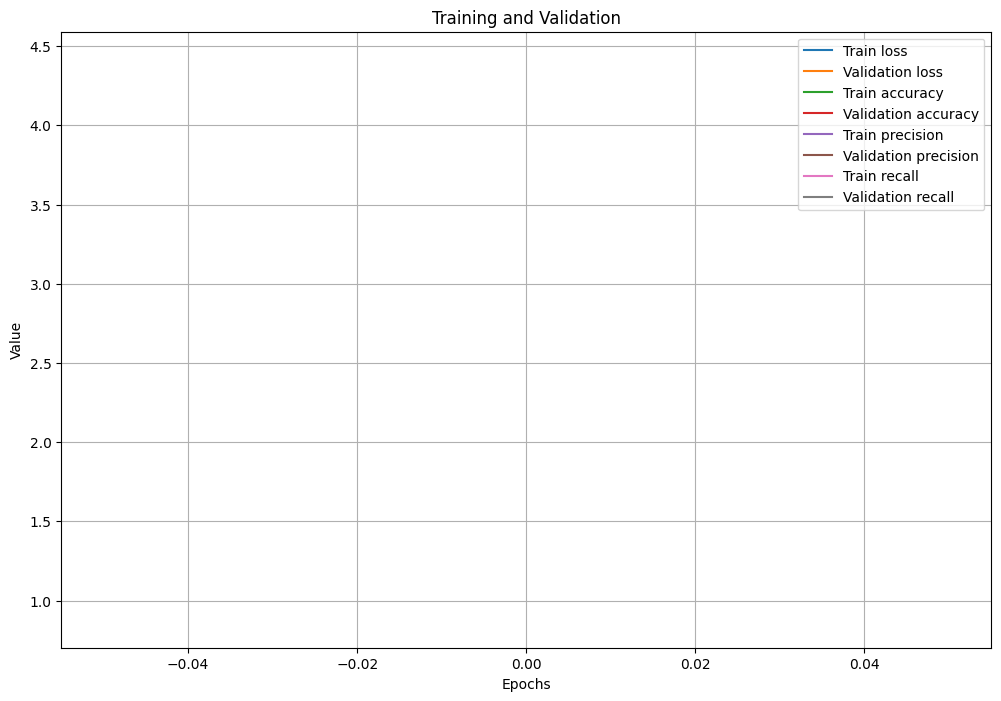

In [12]:
# visualize training metrics
vis.plot_history(history, metrics=["loss", "accuracy", "precision", "recall"])

In [13]:
full_evaluation_dataset = ip.concatenate_datasets(evaluation_data)

test_samples_dict = ip.split_data(dataframe = full_evaluation_dataset, data_columns = [
        "vibration_1_magnitude",
        # "vibration_2_magnitude",
        # "vibration_3_magnitude",
    ],
)

In [14]:
ip.check_data(test_samples_dict)


check_data():
	Class '0 none':	1669.0 samples
	Class '1 slight':	1669.0 samples
	Class '2 moderat':	1667.0 samples
	Class '3 significant':	1669.0 samples
	Class '4 strong':	1669.0 samples


In [15]:
# evaluate model
evaluation = net.evaluate(model=model, test_samples_dict=test_samples_dict, batch_size=BATCH_SIZE)
display(evaluation)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5252 - loss: 6.3405 - precision: 0.5397 - recall: 0.5176


{'accuracy': 0.5283471345901489,
 'loss': 6.334878444671631,
 'precision': 0.5411249995231628,
 'recall': 0.5188781023025513}

### Confusion Matrix
Die Confusion Matrix zeigt, wie gut dein Modell zwischen den verschiedenen Klassen unterscheidet. Jede Zelle stellt die Anzahl der Samples dar, die einer bestimmten Klasse zugeordnet wurden (wahre Labels) und wie das Modell diese Klasse vorhergesagt hat (vorhergesagte Labels).



261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

MODEL PREDICTIONS

[2 2 3 ... 2 1 1]
[1 1 4 ... 1 1 3]
<class 'numpy.ndarray'>


<Figure size 1400x1400 with 0 Axes>

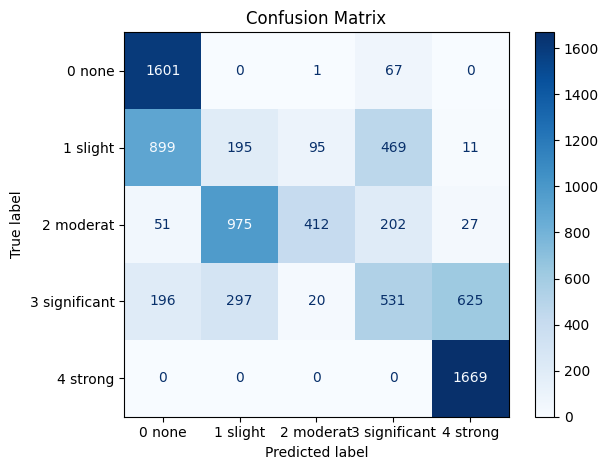

In [ ]:
# predictions by model
true_labels, predicted_labels = net.predict(model=model, test_samples_dict=test_samples_dict)

# plot confusion matrix
vis.plot_confusion_matrix(true_labels=true_labels,
                          predicted_labels=predicted_labels,
                          class_names=test_samples_dict["encoder"].classes_.tolist()
                          )